In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Generate synthetic data
def generate_harder_data(samples=300, features=6, noise=1.5, label_flip_rate=0.05):
    X = np.zeros((samples, features))
    y = np.zeros(samples)
    for i in range(samples):
        cls = i % 3
        y[i] = cls
        if cls == 0:
            X[i] = np.random.normal(loc=0, scale=noise, size=features)
        elif cls == 1:
            X[i] = np.random.normal(loc=2, scale=noise, size=features)
        else:
            X[i] = np.random.normal(loc=4, scale=noise, size=features)
    flip_indices = np.random.choice(samples, int(samples * label_flip_rate), replace=False)
    y[flip_indices] = np.random.choice([0, 1, 2], size=len(flip_indices))
    return X, y.astype(int)

# AIRS-like NSA classifier (with Mahalanobis)
class NSAClassifier:
    def __init__(self, num_detectors=150, mutation_rate=0.1):
        self.num_detectors = num_detectors
        self.mutation_rate = mutation_rate

    def train(self, X, y):
        self.detectors = []
        self.class_cov_inv = {}

        for label in np.unique(y):
            print(f"Generating detectors for class {label}")
            class_samples = X[y == label]
            try:
                cov_inv = inv(np.cov(class_samples.T) + 1e-6 * np.eye(X.shape[1]))  # for Mahalanobis
                self.class_cov_inv[label] = cov_inv
            except LinAlgError:
                print(f"Covariance matrix for class {label} is singular. Using identity matrix.")
                self.class_cov_inv[label] = np.eye(X.shape[1])

            n_detectors = self.num_detectors // len(np.unique(y))
            for _ in range(n_detectors):
                idx = np.random.randint(0, len(class_samples))
                center = class_samples[idx] + np.random.normal(0, self.mutation_rate, size=X.shape[1])
                self.detectors.append({'center': center, 'label': label})

    def predict(self, X):
        preds = []
        for x in X:
            best_label = None
            best_distance = float('inf')
            for det in self.detectors:
                cov_inv = self.class_cov_inv.get(det['label'], np.eye(len(x)))
                dist = distance.mahalanobis(x, det['center'], cov_inv)
                if dist < best_distance:
                    best_distance = dist
                    best_label = det['label']
            preds.append(best_label)
        return np.array(preds)

# Run test
X, y = generate_harder_data(samples=300, features=6, noise=1.5, label_flip_rate=0.05)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

clf = NSAClassifier(num_detectors=150, mutation_rate=0.1)
clf.train(X_train, y_train)
y_pred = clf.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["No Damage", "Minor Damage", "Major Damage"]))

Generating detectors for class 0
Generating detectors for class 1
Generating detectors for class 2
Classification Report:
              precision    recall  f1-score   support

   No Damage       0.91      0.97      0.94        30
Minor Damage       0.95      0.69      0.80        29
Major Damage       0.78      0.94      0.85        31

    accuracy                           0.87        90
   macro avg       0.88      0.86      0.86        90
weighted avg       0.88      0.87      0.86        90



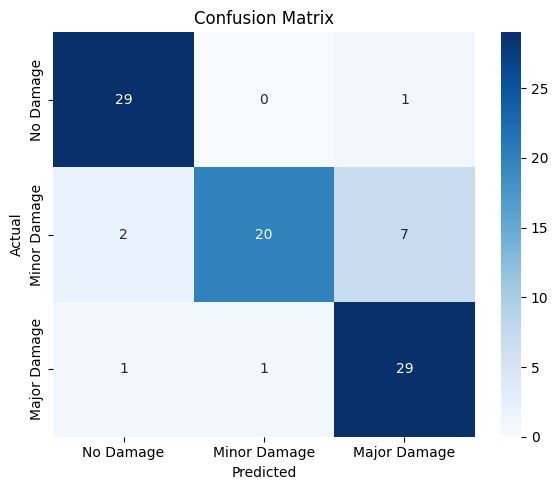

In [34]:
# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["No Damage", "Minor Damage", "Major Damage"],
            yticklabels=["No Damage", "Minor Damage", "Major Damage"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

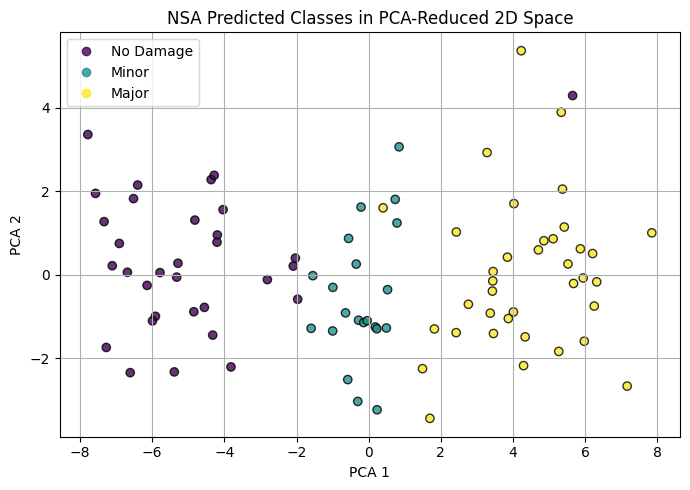

In [35]:
# 2. PCA 2D Projection of Test Set
pca = PCA(n_components=2)
X_test_2D = pca.fit_transform(X_test)
plt.figure(figsize=(7,5))
scatter = plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=y_pred, cmap='viridis', edgecolors='k', alpha=0.8)
plt.legend(handles=scatter.legend_elements()[0], labels=["No Damage", "Minor", "Major"])
plt.title("NSA Predicted Classes in PCA-Reduced 2D Space")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()

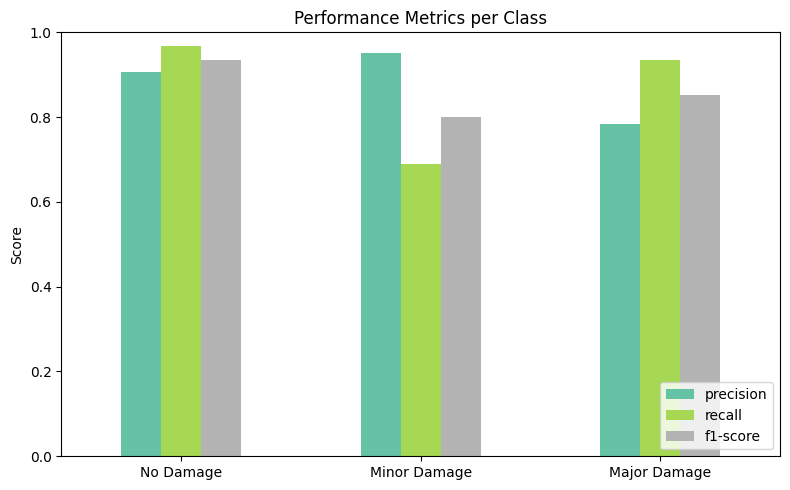

In [36]:
# 3. Bar plot of precision, recall, f1-score
report_dict = classification_report(y_test, y_pred, output_dict=True)
df = pd.DataFrame(report_dict).transpose().iloc[:3][["precision", "recall", "f1-score"]]
df.plot(kind='bar', figsize=(8,5), ylim=(0,1), colormap="Set2", rot=0)
plt.title("Performance Metrics per Class")
plt.ylabel("Score")
plt.xticks(ticks=[0, 1, 2], labels=["No Damage", "Minor Damage", "Major Damage"])
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()